# Simulaciones Laboratorio Sistema 4F y Filtrado Espacial

In [1]:
# Importamos todos los modulos necesarios
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scienceplots
from IPython.display import HTML
from matplotlib.animation import PillowWriter
from scipy.fft import fft2, ifft2, fftfreq, fftshift
from scipy.ndimage import gaussian_filter, rotate
import matplotlib.animation as anim
import PIL
from PIL import ImageFilter
import pint 

In [2]:
plt.style.use(['science', 'notebook'])
u = pint.UnitRegistry()

In [23]:
# Utility functions to process the image 

# Applies fft to ndimage and shifts it to adjust it
def plot2d_ft(signal, plot=False):
    ft = fftshift(fft2(signal))
    if plot:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow(np.log10((np.abs(ft))), cmap='gray')
    return ft

# Reads image file and converts it to gray scale to manage a  ndimage format
def img_2_gray(img_path, plot = False):
    img = PIL.Image.open(img_path)
    img = img.convert("L")
    if plot:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow(img, cmap='gray')

    return np.squeeze(np.asarray(img))

# Reads image file, converts it to grayscale and resizes it to be a square  ndimage
def img_2_gray_512(img_path, plot = False):
    img = PIL.Image.open(img_path)
    img = img.convert("L")
    img = img.resize((512,512))
    if plot:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow(img, cmap='gray')

    return np.squeeze(np.asarray(img))

# Computes ift to ndimage
def plot2d_ift(signal, plot=False):
    ft = (ifft2(signal))
    if plot:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow((np.abs(ft)), cmap='gray')
    return ft

# Applies gaussean filter to ndimage
def gauss_filter(img, alpha, plot=False):
    gauss_img = gaussian_filter(img, alpha)

    if plot:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow((np.abs(gauss_img)), cmap='gray')

    return gauss_img

# Applies gaussean noise to ndimage
def gauss_noise(img, mean, sigma, plot=True):
    gaussian = np.random.normal(mean, sigma, (img.shape[0],img.shape[1])) 
    noise_img = img + gaussian

    if plot:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow((np.abs(noise_img)), cmap='gray')

    return noise_img

# Sharpens image after it's been affected by a gaussean filter of low_pass filter
def sharpen(img, alpha=30, plot=False):
    filter_blurred_f = gaussian_filter(img, 1)
    sharpened = img + alpha * (img - filter_blurred_f)

    if plot:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow((np.abs(sharpened)), cmap='gray')
        
    return sharpened

In [4]:
# We create some masks to craft spacial filters
# All lenghts must be in pixels percent and depends on size of ndimage 

# Adds circular pinhole mask to inpud ndimage 
def circular_mask(image, radius, plot=False):
    # We generate the grid for the circle function
    size_w = image.shape[1]
    size_h = image.shape[0]
    radius = (size_w * radius)/2
    x = np.arange(0, size_w)
    y = np.arange(0, size_h)
    X, Y = np.meshgrid(x, y)
    center_x = size_w // 2
    center_y = size_h // 2
    dist = np.sqrt((X-center_x)**2 + (Y-center_y)**2)
    circle = (dist <= radius).astype(int)

    if plot == True:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow(np.log10(np.abs(image * circle)), cmap='gray')
        
    return image * circle

# Adds circular obstacle mask to input ndimage 
def obstacle_mask(image, radius, plot=False):
    size_w = image.shape[1]
    size_h = image.shape[0]
    radius = (size_w * radius)/2
    x = np.arange(0, size_w)
    y = np.arange(0, size_h)
    X, Y = np.meshgrid(x, y)
    center_x = size_w // 2
    center_y = size_h // 2
    dist = np.sqrt((X-center_x)**2 + (Y-center_y)**2)
    circle = 1 - (dist <= radius).astype(int)

    if plot == True:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow(np.log10(np.abs(image * circle)), cmap='gray')
        
    return image * circle
    
# Adds band pass obstacle mask to input ndimage 
def band_pass(image, inner, outer, plot=False):
   # We generate the grid for the circle function
    size_w = image.shape[1]
    size_h = image.shape[0] 
    inner = (size_w * inner)/2
    outer = (size_h * outer)/2
    x = np.arange(0, size_w)
    y = np.arange(0, size_h)
    X, Y = np.meshgrid(x, y)
    center_x = size_w // 2
    center_y = size_h // 2
    dist = np.sqrt((X-center_x)**2 + (Y-center_y)**2)
    filter = 1 - np.logical_and((dist >= inner) , (dist <= outer))
    

    if plot == True:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow(np.abs(image * filter), cmap='gray')
        
    return image * filter

# Adds slit hole mask to input ndimage 
def slit_mask(image, width, height, angle=0 , plot=False):
    size_w = image.shape[1]
    size_h = image.shape[0]
    w = (width * size_w)
    h = (height * size_h)
    x = np.arange(-size_w/2, size_w/2)
    y = np.arange(-size_h/2, size_h/2)
    X, Y = np.meshgrid(x, y)
    slit = ((np.abs(X) < w/2) * (np.abs(Y) < h/2 )).astype(float)

    if angle != 0:
        slit = rotate(slit, angle, reshape=False)

    if plot == True:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow(np.abs(image * slit), cmap='gray')
        
    return image * slit

# Adds slit obstacle mask to input ndimage 
def slit_obs_mask(image, width, height, angle=0, plot=False):
    size_w = image.shape[1]
    size_h = image.shape[0]
    w = (width * size_w)
    h = (height * size_h)
    x = np.arange(-size_w/2, size_w/2)
    y = np.arange(-size_h/2, size_h/2)
    X, Y = np.meshgrid(x, y)
    slit = 1 - ((np.abs(X) < w/2) * (np.abs(Y) < h/2 )).astype(float)

    if plot == True:
        plt.figure(num=None, figsize=(8, 6), dpi=80)
        plt.imshow(np.abs(image * slit), cmap='gray')
        
    return image * slit

In [31]:
# It's recommended to use pint with this function to get the units right

# We write functions to convert from pixel size to percent image
def m_to_pc(image, pix_size, dist):
    size = len(image)
    real_size = pix_size * size 

    return dist/real_size

## Operaciones de Filtrado Espacial

### Filtros Paso Bajo

Realizamos las operaciones de procesamiento a partir de la siguiente imagen del emperador Maxiemiliano.

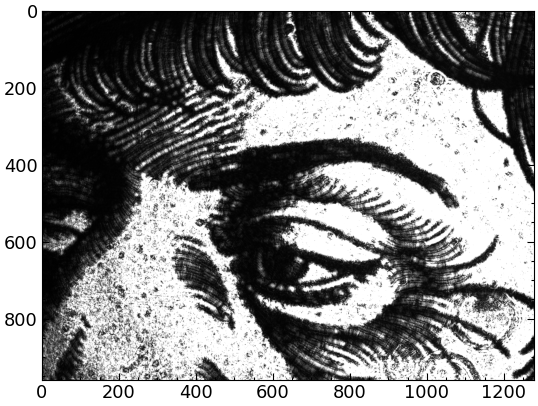

In [33]:
maxim = img_2_gray('Imagenes/maxim2_exp-12.bmp', plot=True)

Se debe tener en cuenta que el tamaño de pixel de la cámara es de $3.75\mu m$ X $3.75\mu m$, deacuerdo a esto el tamaño de la real de la imagen es de:


In [7]:
maxim.shape

(960, 1280)

In [8]:
display((np.array([maxim.shape[0], maxim.shape[1]]) * 3.75 * u.micrometer).to('mm'))

Magnitude,[3.6 4.8]
Units,millimeter


Ahora cargamos las imagenes obtenidas en el laboratorio y las comparamos con los datos obtenidos en la simulación.

In [34]:
maxim_1mm = img_2_gray('Imagenes/maxim2_baja(1mm).bmp', plot=False)
maxim_05mm = img_2_gray('Imagenes/maxim2_baja(0.5mm).bmp', plot=False)
maxim_025mm = img_2_gray('Imagenes/maxim2_baja(0.25mm).bmp', plot=False)

analog = [maxim_1mm, maxim_05mm, maxim_025mm]

Aplicamos filtros pasabajo, esto es mascaras circulares, en el plano de fourier a la imagen original para simular los resultados analógicos. 

In [35]:
# Filtro pasabajo de 1mm de diámetro
maximd_ft= plot2d_ft(maxim)

# 1mm diameter
r = 0.5 * u.mm
pix_size = 3.75 * u.micrometer
radius = m_to_pc(maximd_ft, pix_size, r)
maximd_1mm = circular_mask(maximd_ft, radius, plot=False)
maximd_1mm = plot2d_ift(maximd_1mm, plot=False)

# 0.5mm diameter
r = 0.25 * u.mm
pix_size = 3.75 * u.micrometer
radius = m_to_pc(maximd_ft, pix_size, r)
maximd_05mm = circular_mask(maximd_ft, radius, plot=False)
maximd_05mm = plot2d_ift(maximd_05mm, plot=False)

# 0.25mm diameter
r = 0.125 * u.mm
pix_size = 3.75 * u.micrometer
radius = m_to_pc(maximd_ft, pix_size, r)
maximd_025mm = circular_mask(maximd_ft, radius, plot=False)
maximd_025mm = plot2d_ift(maximd_025mm, plot=False)

digital = [maximd_1mm, maximd_05mm, maximd_025mm]

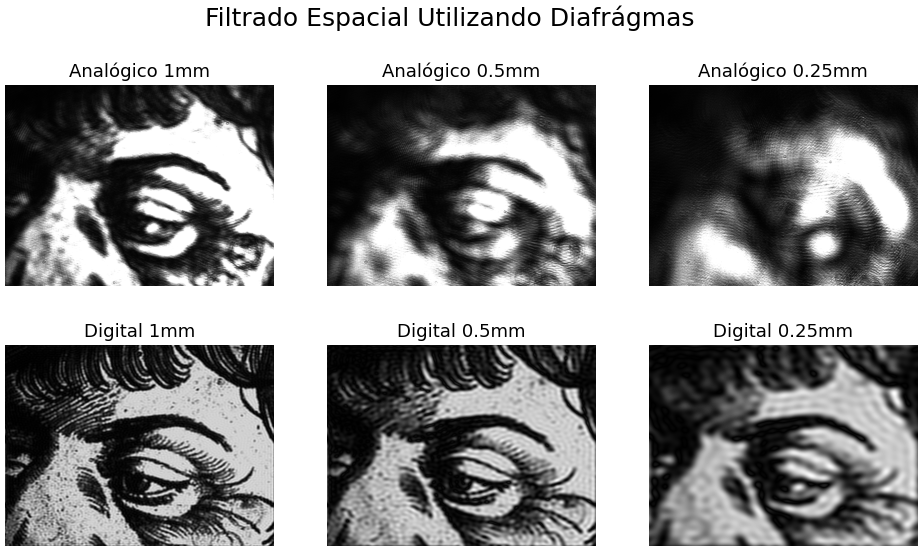

In [36]:
# Now we plot the images in a grid
f, axarr = plt.subplots(2, 3, figsize=(10, 8))
filters = ['1mm', '0.5mm', '0.25mm']

f.tight_layout()

for i, img in enumerate(analog):
    axarr[0, i].imshow(np.abs(analog[i]), cmap='gray')
    axarr[1, i].imshow(np.abs(digital[i]), cmap='gray')
    
    axarr[0, i].set_axis_off()
    axarr[1, i].set_axis_off()

    axarr[0, i].set_title(f'Analógico {filters[i]}', fontsize=13)
    axarr[1, i].set_title(f'Digital {filters[i]}', fontsize=13)

f.subplots_adjust(wspace=0.2, hspace=-0.45)
f.suptitle('Filtrado Espacial Utilizando Diafrágmas', x=0.5, y=0.9, fontsize=18)

plt.show()
    

### Filtros Paso Alto 

Cargamos las imagenes obtenidas en el laboratorio.

In [40]:
maximh_1mm = img_2_gray('Imagenes/maxim2_alta(1mm).bmp', plot=False)
maximh_05mm = img_2_gray('Imagenes/maxim2_alta(0.5mm).bmp', plot=False)
maximh_025mm = img_2_gray('Imagenes/maxim2_alta(0.25mm).bmp', plot=False)

analog_obs = [maximh_1mm, maximh_05mm, maximh_025mm]

Aplicamos filtros pasa-alto, esto es obstáculos circulares, en el plano de fourier a la imagen original para simular los resultados analógicos. 

In [41]:
# 1mm
r = 0.5 * u.mm
pix_size = 3.75 * u.micrometer
radius = m_to_pc(maximd_ft, pix_size, r)
maximdh_1mm = obstacle_mask(maximd_ft, radius, plot=False)
maximdh_1mm = plot2d_ift(maximdh_1mm, plot=False)

# 0.5mm
r = 0.25 * u.mm
pix_size = 3.75 * u.micrometer
radius = m_to_pc(maximd_ft, pix_size, r)
maximdh_05mm = obstacle_mask(maximd_ft, radius, plot=False)
maximdh_05mm = plot2d_ift(maximdh_05mm, plot=False)

# 0.25mm
r = 0.125 * u.mm
pix_size = 3.75 * u.micrometer
radius = m_to_pc(maximd_ft, pix_size, r)
maximdh_025mm = obstacle_mask(maximd_ft, radius, plot=False)
maximdh_025mm = plot2d_ift(maximdh_025mm, plot=False)

digital_obs = [maximdh_1mm, maximdh_05mm, maximdh_025mm]

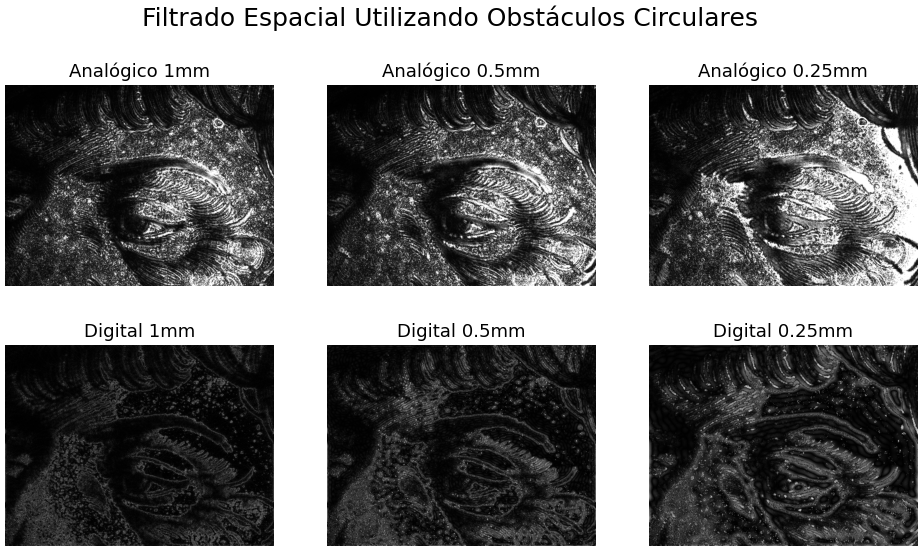

In [42]:
# Now we plot the images in a grid
f, axarr = plt.subplots(2, 3, figsize=(10, 8))
filters = ['1mm', '0.5mm', '0.25mm']

f.tight_layout()

for i, img in enumerate(analog_obs):
    axarr[0, i].imshow(np.abs(analog_obs[i]), cmap='gray')
    axarr[1, i].imshow(np.abs(digital_obs[i]), cmap='gray')
    
    axarr[0, i].set_axis_off()
    axarr[1, i].set_axis_off()

    axarr[0, i].set_title(f'Analógico {filters[i]}', fontsize=13)
    axarr[1, i].set_title(f'Digital {filters[i]}', fontsize=13)

f.subplots_adjust(wspace=0.2, hspace=-0.45)
f.suptitle('Filtrado Espacial Utilizando Obstáculos Circulares', x=0.5, y=0.9, fontsize=18)

plt.show()

### Filtrado Utilizando Rendijas

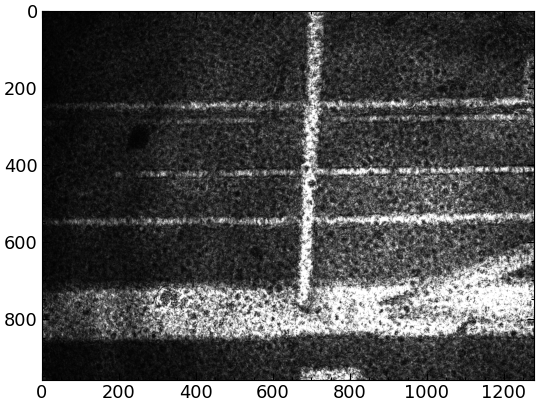

In [43]:
cercha = img_2_gray('Imagenes/metro_exp-11.bmp', plot=True)

Veamos las dimensiones reales de la imagen

In [44]:
cercha.shape

(960, 1280)

In [45]:
display((np.array([maxim.shape[0], maxim.shape[1]]) * 3.75 * u.micrometer).to('mm'))

Magnitude,[3.6 4.8]
Units,millimeter


Primero utilizamos una mascara de rendija horizontal para eliminar las lineas verticales de la cercha

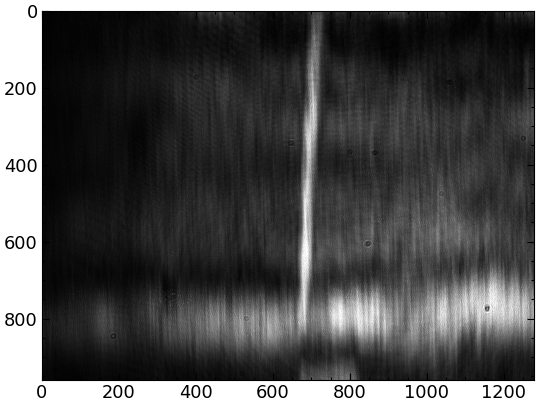

In [49]:
# Cargamos los resultados experimentales
cercha_rend02mm = img_2_gray('Imagenes/metro_rendijaHorizontal(0.2mm).bmp', plot=True)

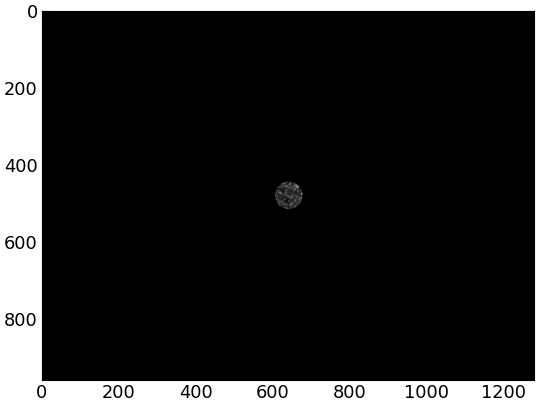

In [47]:
h = 3.6 * u.mm # Height of all the image
l = 0.2 * u.mm
pix_size = 3.75 * u.micrometer

cerchad = circular_mask(cercha, lp, plot=True )

